En este ejercicio, trabajarás en el problema "Happy House", que explicaremos a continuación. ¡Carguemos los paquetes requeridos y resolvamos el problema de Happy House!

In [159]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from PIL import Image
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from kt_utils import *
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')


[tf.keras.backend.set_image_data_format(...)](https://www.tensorflow.org/api_docs/python/tf/keras/backend/set_image_data_format) : Convención de formato de datos de imagen

## 1 - The Happy House 
Para tus próximas vacaciones, decidiste pasar una semana con cinco de tus amigos de la escuela. Es una casa muy conveniente con muchas cosas que hacer cerca. Pero el beneficio más importante es que todos se han comprometido a ser felices cuando están en la casa. Así que cualquiera que quiera entrar en la casa debe demostrar su estado actual de felicidad.

<img src="images/happy-house.jpg" style="width:350px;height:270px;">
<caption><center><u><font color='purple'> **Figure 1** </u><font color='purple'>:**the Happy House**</center></caption>

Como experto en aprendizaje profundo, para asegurarse de que la regla "Happy" se aplique estrictamente, construirá un algoritmo que utiliza imágenes de la cámara de la puerta principal para verificar si la persona está feliz o no. La puerta debe abrirse solo si la persona está feliz. 

Has reunido fotos de tus amigos y de ti mismo, tomadas por la cámara de la puerta principal. El conjunto de datos está etiquetada. 

<img src="images/house-members.png" style="width:550px;height:250px;">

Ejecute el código siguiente para normalizar el conjunto de datos y obtener información sobre sus formas.

In [160]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalizamos las images 
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reformamos de (c, m) a (m, c)
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


**Detalles del dataset "Happy"**:
- Images are of shape (64,64,3)
- Training: 600 pictures
- Test: 150 pictures


## 2 - Construyendo un modelo en Keras

Aplicaremos la arquitectura de [LeNet-5](https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/) 

In [161]:
# De acuerdo a la forma de entrada de LeNet-5, cambiamos el tamaño de de 64x64 a 32x32
import cv2
def resize(X, size = (32,32)):
    # size : (width, height)
    m = len(X)
    X_resize = np.zeros((m, *size, X.shape[-1]))
    for i in range(m):
        X_resize[i] = cv2.resize(X[i], size , interpolation=cv2.INTER_CUBIC)
    
    return X_resize
    

In [162]:
X_train_resize = resize(X_train)
X_test_resize = resize(X_test)

print(f'Nueva forma de X_train: {X_train_resize.shape}')
print(f'Nueva forma de X_test: {X_test_resize.shape}')

Nueva forma de X_train: (600, 32, 32, 3)
Nueva forma de X_test: (150, 32, 32, 3)


In [174]:
# Arquitectura similar a LeNet-5 adaptado a una clasficacion binaria
model = tf.keras.Sequential(
    [Conv2D(filters = 6, kernel_size = 5, strides = 1, padding = 'valid', input_shape = (32,32,3), activation = "relu"),
    AveragePooling2D(pool_size = 2, strides = 2),
    Conv2D(16, 5, strides = 1, activation = 'relu'),
    AveragePooling2D(pool_size = 2, strides = 2),
    Flatten(),
    Dense(120, activation = 'relu'),
    Dense(84, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
     ]
)
    

In [183]:
# Callback de EarlyStopping
stop = tf.keras.callbacks.EarlyStopping(min_delta = 0.001, patience = 20, restore_best_weights = True)

In [202]:
# Compilacion del modelo
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 0.01),
              metrics = ['accuracy'])

In [206]:
# Ajuste del modelo
history = model.fit(X_train_resize, Y_train, epochs = 30, validation_data = (X_test_resize, Y_test), 
                    callbacks = [stop])

Epoch 1/30
19/19 [==============================] - 0s 21ms/step - loss: 0.0386 - accuracy: 0.9867 - val_loss: 0.2956 - val_accuracy: 0.9267
Epoch 2/30
19/19 [==============================] - 1s 27ms/step - loss: 0.0143 - accuracy: 0.9950 - val_loss: 0.3654 - val_accuracy: 0.9400
Epoch 3/30
19/19 [==============================] - 1s 28ms/step - loss: 0.0312 - accuracy: 0.9900 - val_loss: 0.3919 - val_accuracy: 0.9333
Epoch 4/30
19/19 [==============================] - 0s 25ms/step - loss: 0.0316 - accuracy: 0.9917 - val_loss: 0.2999 - val_accuracy: 0.9400
Epoch 5/30
19/19 [==============================] - 1s 28ms/step - loss: 0.0184 - accuracy: 0.9950 - val_loss: 0.3258 - val_accuracy: 0.9533
Epoch 6/30
19/19 [==============================] - 1s 27ms/step - loss: 0.0280 - accuracy: 0.9917 - val_loss: 0.3201 - val_accuracy: 0.9267
Epoch 7/30
19/19 [==============================] - 1s 27ms/step - loss: 0.1006 - accuracy: 0.9717 - val_loss: 0.2275 - val_accuracy: 0.9400
Epoch 8/30
19

In [207]:
model.evaluate(X_test_resize, Y_test)

5/5 [==============================] - 0s 5ms/step - loss: 0.3499 - accuracy: 0.9533


[0.34987249970436096, 0.95333331823349]

# 3-Visualización

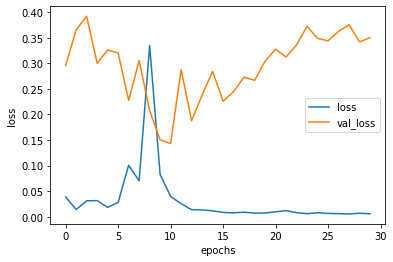

In [208]:
# Curva de aprendizaje
pd.DataFrame(history.history)[['loss', 'val_loss']].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

In [209]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
average_pooling2d_16 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_17 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_25 (Dense)             (None, 84)               

In [210]:
# Predicciones en nuestro conjunto de prueba
probs = model.predict(X_test_resize)
preds = np.round(probs)

True label: 0  Prediction : 0


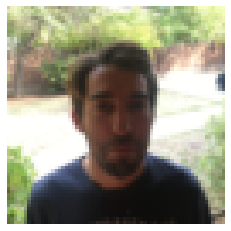

In [211]:
# Visualización de un ejemplo
m = Y_test.shape[0]
index = np.random.randint(m)
print(f'True label: {int(Y_test[index])}  Prediction : {int(np.round(model.predict(X_test_resize[index:index+1])))}')
plt.imshow(X_test_orig[index], cmap = plt.cm.Spectral)
plt.axis(False);


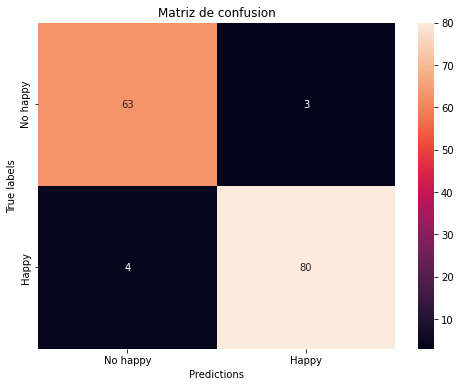

In [212]:
# Matriz de confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(Y_test, preds), xticklabels = ["No happy", "Happy"], yticklabels = ["No happy", "Happy"], 
            annot = True, fmt = '.2g');
plt.title('Matriz de confusion')
plt.xlabel('Predictions')
plt.ylabel('True labels');

Prediction : Feliz


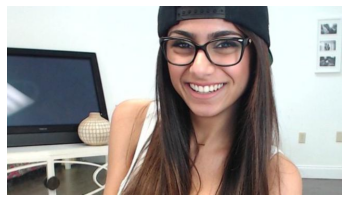

In [214]:
# En un ejemplo propio
example = np.array(Image.open('images/test_image.jpg'))
example_resize = resize(example.reshape(1, *example.shape ))
print(f'Prediction : { "Feliz" if int(np.round(model.predict(example_resize))) == 1 else "Infeliz"}')
plt.imshow(example, cmap = plt.cm.Spectral)
plt.axis(False);

Prediction : Infeliz


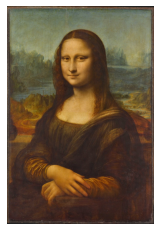

In [215]:
# En un ejemplo propio
example = np.array(Image.open('images/gioconda.jpg'))
example_resize = resize(example.reshape(1, *example.shape ))
print(f'Prediction : { "Feliz" if int(np.round(model.predict(example_resize))) == 1 else "Infeliz"}')
plt.imshow(example, cmap = plt.cm.Spectral)
plt.axis(False);

Prediction : Feliz


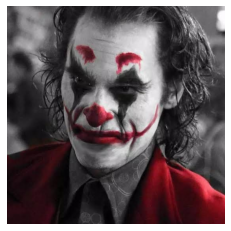

In [218]:
# En un ejemplo propio
example = np.array(Image.open('images/guason.jpg'))
example_resize = resize(example.reshape(1, *example.shape ))
print(f'Prediction : { "Feliz" if int(np.round(model.predict(example_resize))) == 1 else "Infeliz"}')
plt.imshow(example, cmap = plt.cm.Spectral)
plt.axis(False);